In [95]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cvxpy as cp
import pandas as pd
from sklearn.utils import shuffle

In [96]:
def load_file_to_df(filename, shuf=True):
    return_df = pd.read_csv(filename)
    if shuf==True:
        return_df = shuffle(return_df)
    return_df = return_df.reset_index(drop=True)
    return return_df

In [97]:
def load_df(i, df):
    temp_df = df.loc[df['Digit'] == i]
    temp_df = temp_df.drop(labels=['Digit'], axis='columns')
    temp_df = temp_df.reset_index(drop=True)
    return temp_df

In [98]:
rawFile = "studentspen-train.csv"
rawDatadf = load_file_to_df(rawFile, True)
rawDatadf.head()

,x3,y3,x4,y4,x5,y5,x6,y6,Digit
0,89,85,75,57,42,32,0,11,2
1,77,99,100,100,78,76,57,51,1
2,28,56,10,28,21,0,69,6,6
3,89,80,57,52,17,30,0,5,2
4,94,83,75,47,39,18,0,0,2


In [107]:
# Use this for a 80/20 train test split
print('Splitting')
splitIdx = round(.8*len(rawDatadf))
train_df = rawDatadf[:splitIdx]
test_df = rawDatadf[splitIdx:]
print(len(train_df))

Splitting
2998


In [101]:
# Use this for training on 100% of data
train_df = rawDatadf
print(len(train_df))

3747


In [89]:
#One Vs Rest
dfs = []
for i in range(10):
    temp_df = load_df(i, train_df)
    dfs.append(temp_df)

In [108]:
# PART 1 TRAIN
weights, bs, epsilons = [], [], []
D = 8
C = 2

for i in range(10):
    data1= dfs[i].to_numpy()
    rest = []
    for j in range(10):
        if i != j:
            rest.append(dfs[j])
    restdf = pd.concat(rest,ignore_index=True, sort=False)
    data2 = restdf.to_numpy()

    N1 = data1.shape[0]
    N2 = data2.shape[0]

    # normalize by dividing by 100
    data1 = data1 / 100
    data2 = data2 / 100

    X = np.concatenate((data1,data2), axis = 0)
    y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis = 0)

    w = cp.Variable((D,1))
    b = cp.Variable()

    epsilon = cp.Variable((N1+N2, 1))
    #soft margin... slack variable is epsilon
    objective = cp.Minimize(cp.sum(cp.square(w))*.5 + cp.sum(cp.square(epsilon)*C))
    constraints = [cp.multiply(y, (X @ w + b)) >= 1 - epsilon, epsilon >= 0]
    prob = cp.Problem(objective,constraints)
    prob.solve()


    weights.append(w.value.reshape(-1))
    bs.append(b.value)
    epsilons.append(epsilon.value)

In [109]:
W = np.array(weights)
BS = np.array(bs)
EP = np.array(epsilon)
# print(W)
# print(EP)

In [110]:
# Empirical performance estimate
correct = 0
instances = test_df.shape[0]
test_val, preds = [], []
for i in range(instances):
    testData = test_df.iloc[i].to_numpy()
    cur_x = testData[:8] / 100
    cur_y = testData[8]
    pred = np.argmax(W.dot(cur_x)+BS)
    test_val.append(cur_y)
    preds.append(pred)
    if pred == cur_y:
        correct += 1
print(correct, instances, correct/instances)

562 749 0.7503337783711616


In [104]:
# Theoretical Bound (using P(error) >= N_s / N_instances)
def find_num_support_vec(data1, data2, weight, b, slack, thresh):
    N1 = data1.shape[0]
    N2 = data2.shape[0]
    X = np.concatenate((data1, data2), axis=0)
    y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis=0)
    suppVecs = y * (X.dot(weight) + b) - 1 + slack
    svList = ((-thresh<suppVecs) & (suppVecs<thresh)).flatten()
    # print(svList)
    svX, svY = X[svList], y[svList]
    # print(svX)
    # print(svY)

    return np.sum(svList), svX, svY

totalSV = 0
totalSVList = []
threshold = 1e-8
for i in range(10):

    data1= dfs[i].to_numpy()
    rest = []
    for j in range(10):
        if i != j:
            rest.append(dfs[j])
    restdf = pd.concat(rest,ignore_index=True, sort=False)
    data2 = restdf.to_numpy()

    data1 = data1 / 100
    data2 = data2 / 100

    curW = weights[i].reshape(-1, 1)
    curB = bs[i]
    curSlack = epsilons[i]
    print('index: ', i)
    num, svX, svY = find_num_support_vec(data1, data2, curW, curB, curSlack, threshold)
    totalSVList.append(num)
    totalSV += totalSVList[i]
t = np.array(totalSVList)
instances = data1.shape[0] + data2.shape[0]
# print(totalSVList)
# print(np.array(totalSVList)/instances)
print(totalSV)
print(instances*10)
print(1 - (totalSV/(instances*10)))

index:  0
index:  1
index:  2
index:  3
index:  4
index:  5
index:  6
index:  7
index:  8
index:  9
12435
37470
0.668134507606085


In [105]:
# Get predictions on test set (make sure to train on whole dataset, dont use split)
test_df = pd.read_csv("studentsdigits-test.csv")

instances = test_df.shape[0]
preds = []
for i in range(instances):
    testData = test_df.iloc[i].to_numpy()
    cur_x = testData[:8] / 100
    pred = np.argmax(W.dot(cur_x)+BS)
    preds.append(pred)
print(len(preds))
save_array = np.array(preds)
np.savetxt("convertLater.txt", save_array, delimiter=", ")

3747


In [111]:
#cross validate
percent_correct = []
for iterator in range(100):
    if iterator % 10 == 0:
        print(iterator)
    rawData = load_file_to_df("studentspen-train.csv", True)
    rawData.head()
    # rawData = pd.read_csv("studentspen-train.csv")
    # rawData = shuffle(rawData)
    # rawData = rawData.reset_index(drop=True)
    # rawData.head()
    splitIdx = round(.8*len(rawData))
    train_df = rawData[:splitIdx]
    test_df = rawData[splitIdx:]
    #print(len(train_df))
    dfs = []
    for i in range(10):
        temp_df= train_df.loc[rawData['Digit'] == i]
        temp_df = temp_df.drop(labels=['Digit'], axis='columns')
        temp_df = temp_df.reset_index(drop=True)
        dfs.append(temp_df)
    weights, bs = [], []
    for i in range(10):
        data1= dfs[i].to_numpy()
        rest = []
        for j in range(10):
            if j != i:
                rest.append(dfs[j])
        restdf = pd.concat(rest,ignore_index=True, sort=False)
        data2 = restdf.to_numpy()

        D = 8
        C = 2
        N1 = data1.shape[0]
        N2 = data2.shape[0]

        data1 = data1 / 100
        data2 = data2 / 100

        X = np.concatenate((data1,data2), axis = 0)
        y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis = 0)

        w = cp.Variable((D,1))
        b = cp.Variable()
        epsilon = cp.Variable((N1+N2, 1))
        #soft margin SVM
        objective = cp.Minimize(cp.sum(cp.square(w))*.5 + cp.sum(cp.square(epsilon)*C))
        constraints = [cp.multiply(y, (X @ w + b)) >= 1 - epsilon, epsilon >= 0]
        prob = cp.Problem(objective,constraints)
        prob.solve()

        weights.append(w.value.reshape(-1))
        bs.append(b.value)
    W = np.array(weights)
    BS = np.array(bs)
    #print(W)
    correct = 0
    total = test_df.shape[0]
    test_val, preds = [], []
    for i in range(total):
        data = test_df.iloc[i].to_numpy()
        cur_x = data[:8] / 100
        cur_y = data[8]
        pred = np.argmax(W.dot(cur_x)+BS)
        test_val.append(cur_y)
        preds.append(pred)
        if pred == cur_y:
            correct += 1
    percent_correct.append(correct/total)
    #print(correct, total, correct/total)
print(sum(percent_correct)/len(percent_correct))

0
10
20
30
40
50
60
70
80
90
0.7309212283044058


In [22]:
# 4a
transfer_train_file = "transfer_train-1.csv"

trans_df = load_file_to_df(transfer_train_file, True)
trans_df.head()

trans_1_df = load_df(1, trans_df)
trans_7_df = load_df(7, trans_df)

D=8
C=2


# to numpy and normalize
data1 = trans_1_df.to_numpy() / 100
data2 = trans_7_df.to_numpy() / 100


N1 = data1.shape[0]
N2 = data2.shape[0]

X = np.concatenate((data1,data2), axis = 0)
y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis = 0)

w = cp.Variable((D,1))
b = cp.Variable()

epsilon = cp.Variable((N1+N2,1))
objective = cp.Minimize(cp.sum(cp.square(w))*.5 + cp.sum(cp.square(epsilon)*C))
constraints = [cp.multiply(y, (X @ w + b)) >= 1 - epsilon, epsilon >= 0]
prob = cp.Problem(objective,constraints)
prob.solve()

weight = w.value.reshape(-1)
bValue = b.value

W = w.value.reshape(-1)
print(W)
BS = np.array(b)
EP = np.array(epsilon)


#test
test_df = pd.read_csv("transfer_test-1.csv")
correct = 0
total = test_df.shape[0]
test_val, preds = [],[]
for i in range(total):
    data = test_df.iloc[i].to_numpy()
    cur_x = data[:8] / 100
    cur_y = data[8]
    pred = 0

    if(W.dot(cur_x)+bValue < 0):
        pred = 7
    else:
        pred = 1

    test_val.append(cur_y)
    preds.append(pred)
    if pred == cur_y:
        correct += 1
print(correct, total, correct/total)


[-0.54125199 -0.05471902 -0.82309194  1.00524253  0.33927981  0.63775039
  0.24126055 -0.1523344 ]
596 754 0.7904509283819628


In [94]:
# 4b
rawFile = "studentspen-train.csv"
rawDatadf = load_file_to_df(rawFile, True)
rawDatadf.head()

transfer_train_file = "transfer_train-1.csv"
trans_df = load_file_to_df(transfer_train_file, True)
trans_df.head()

H_df1 = load_df(1, rawDatadf)
H_df9 = load_df(9, rawDatadf)


T_df1 = load_df(1, trans_df)
T_df7 = load_df(7, trans_df)

D=8
C=2

# To numpy and normalize
data1 = H_df1.to_numpy() / 100
data2 = H_df9.to_numpy() / 100


N1 = data1.shape[0]
N2 = data2.shape[0]
X = np.concatenate((data1,data2), axis = 0)
y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis = 0)

w = cp.Variable((D,1))
b = cp.Variable()

epsilon = cp.Variable((N1+N2,1))
objective = cp.Minimize(cp.sum(cp.square(w))*.5 + cp.sum(cp.square(epsilon)*C))
constraints = [cp.multiply(y, (X @ w + b)) >= 1 - epsilon, epsilon >= 0]
prob = cp.Problem(objective,constraints)
prob.solve()

weight = w.value.reshape(-1)
bValue = b.value
W = np.array(weight)
BS = np.array(bs)
EP = np.array(epsilon)

# hypothesis transfer 
D=8
C=2

data1 = T_df1.to_numpy() / 100
data2 = T_df7.to_numpy() / 100


N1 = data1.shape[0]
N2 = data2.shape[0]
X = np.concatenate((data1,data2), axis = 0)
y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis = 0)

w_trans = cp.Variable((D,1))
b_trans = cp.Variable()
epsilon = cp.Variable((N1+N2,1))
objective = cp.Minimize(cp.sum(cp.square(w_trans))*.5 + cp.sum(cp.square(epsilon)*C))
constraints = [cp.multiply(y, (X @ (w.value+w_trans) + b_trans)) >= 1 - epsilon, epsilon >= 0]
prob = cp.Problem(objective,constraints)
prob.solve()

www = w+w_trans
weight = www.value.reshape(-1)
bValue = b_trans.value

W = weight
print(W)



#test
test_df = pd.read_csv("transfer_test-1.csv")
correct = 0
total = test_df.shape[0]
test_val, preds = [],[]
for i in range(total):
    rec = test_df.iloc[i].to_numpy()
    cur_x = rec[:8] / 100
    cur_y = rec[8]

    if(W.dot(cur_x)+bValue < 0):
        pred = 7
    else:
        pred = 1
    test_val.append(cur_y)
    preds.append(pred)
    if pred == cur_y:
        correct += 1
        
print(correct, total, correct/total)

[-0.78243523  1.44413303  0.86619122  0.65775158  1.15064915 -0.72687133
 -1.34627808  1.82157305]
594 754 0.7877984084880637


In [25]:
#4c
#Instance: train an SVM on a new problem where 1 is positive and (7 & 9) are negative. 
rawFile = "studentspen-train.csv"
rawDatadf = load_file_to_df(rawFile, False)
rawDatadf.head()

transfer_train_file = "transfer_train-1.csv"
trans_df = load_file_to_df(transfer_train_file, False)
trans_df.head()

H_df1 = load_df(1, rawDatadf)
H_df9 = load_df(9, rawDatadf)


T_df1 = load_df(1, trans_df)
T_df7 = load_df(7, trans_df)


D=8
C=2

# To numpy and normalize
data1 = H_df1.to_numpy() / 100
data2 = H_df9.to_numpy() / 100

N1 = data1.shape[0]
N2 = data2.shape[0]

X = np.concatenate((data1, data2), axis=0)
y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis=0)


w = cp.Variable((D,1))
b = cp.Variable()
epsilon = cp.Variable((N1+N2,1))
objective = cp.Minimize(cp.sum(cp.square(w))*.5 + cp.sum(cp.square(epsilon)*C))
constraints = [cp.multiply(y, (X @ w + b)) >= 1 - epsilon, epsilon >= 0]
prob = cp.Problem(objective,constraints)
prob.solve()

threshold = 1e-20
print('here')
numSV, svX, svY = find_num_support_vec(data1, data2, w.value, b.value, epsilon.value, threshold)
# print('Support Vecs:')
# print(svX)

D = 8
C = 10

data1 = T_df1.to_numpy() / 100
data2 = T_df7.to_numpy() / 100

N1 = data1.shape[0]
N2 = data2.shape[0]
N3 = svX.shape[0]
X = np.concatenate((data1, data2), axis=0)
y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis=0)

w_trans = cp.Variable((D, 1))
b_trans = cp.Variable()
epsilon = cp.Variable((N1+N2, 1))
epsilon2 = cp.Variable((N3, 1))
objective = cp.Minimize(cp.sum(cp.square(w_trans))*0.5 + cp.sum((epsilon)*C) + cp.sum((epsilon2)*C))
constraints = [cp.multiply(y, (X @ w_trans + b_trans)) >= 1 - epsilon, cp.multiply(svY, (svX @ w_trans + b_trans)) >= 1 - epsilon2,  epsilon >= 0, epsilon2 >= 0]

prob = cp.Problem(objective, constraints)
prob.solve()
W = w_trans.value.reshape(-1)
B = b_trans.value

#test
test_df = pd.read_csv("transfer_test-1.csv")
correct = 0
total = test_df.shape[0]
test_val, preds = [],[]
for i in range(total):
    data = test_df.iloc[i].to_numpy()
    cur_x = data[:8] / 100
    cur_y = data[8]

    if((W.dot(cur_x)+B) < 0):
        pred = 7
    else:
        pred = 1
    test_val.append(cur_y)
    preds.append(pred)
    if pred == cur_y:
        correct += 1

print(correct, total, correct/total)

here
612 754 0.8116710875331565


In [27]:
fileName = 'convertLater.txt'
outFile = 'JoshPike_predictions.txt'
# JoshPike_preds_clustering.txt
# JoshPike_preds_DL.txt

answerFile = open(fileName, 'r')
lines = answerFile.readlines()
print(len(lines))
writeFile = open(outFile, 'w')

convert = []
count = 0
for line in lines:
    count+=1
    print(count)
    print(int(float(line)))
    convert.append(str(int(float(line))) + '\n')
    
print(len(convert))
# save_array = np.array(convert)
# print(save_array)
writeFile.writelines(convert)
# np.savetxt(outFile, save_array, delimiter =", ")

3747
1
7
2
1
3
0
4
6
5
4
6
5
7
6
8
3
9
5
10
1
11
6
12
6
13
6
14
3
15
5
16
4
17
7
18
2
19
1
20
9
21
6
22
6
23
3
24
0
25
9
26
1
27
1
28
2
29
0
30
3
31
4
32
1
33
1
34
0
35
9
36
9
37
6
38
4
39
9
40
6
41
6
42
4
43
0
44
5
45
9
46
8
47
7
48
7
49
6
50
2
51
4
52
0
53
7
54
3
55
3
56
9
57
0
58
3
59
0
60
1
61
4
62
0
63
0
64
6
65
5
66
5
67
9
68
1
69
1
70
4
71
9
72
5
73
3
74
6
75
3
76
6
77
3
78
6
79
4
80
3
81
7
82
7
83
4
84
3
85
1
86
7
87
7
88
0
89
0
90
7
91
7
92
1
93
5
94
3
95
0
96
9
97
2
98
0
99
9
100
1
101
3
102
1
103
3
104
5
105
6
106
6
107
3
108
1
109
6
110
2
111
6
112
4
113
7
114
5
115
3
116
4
117
2
118
4
119
2
120
3
121
4
122
5
123
4
124
2
125
0
126
3
127
2
128
9
129
1
130
6
131
2
132
0
133
7
134
7
135
9
136
5
137
2
138
1
139
2
140
9
141
7
142
0
143
1
144
4
145
6
146
2
147
7
148
4
149
2
150
4
151
4
152
6
153
7
154
5
155
5
156
0
157
6
158
0
159
0
160
2
161
3
162
3
163
7
164
5
165
3
166
9
167
7
168
7
169
6
170
4
171
7
172
2
173
0
174
1
175
5
176
5
177
7
178
4
179
7
180
9
181
7
182
7
183
7
184
1

status: optimal
optimal value 160.125241949287
optimal var w = [[-16.31924091]
 [ -7.34389951]], b = 21.88583165858434
X and Y Shape
21.88583165858434
[[ 2.66338507e+01]
 [ 3.17809033e+01]
 [ 1.32854912e+01]
 [ 2.49072167e+00]
 [ 2.54761553e+01]
 [ 7.63476020e+00]
 [ 3.87209835e+01]
 [ 1.46307500e+01]
 [ 3.37562177e+01]
 [ 2.14730985e+01]
 [ 9.23696460e+00]
 [ 2.93161717e+01]
 [ 1.35302164e+01]
 [ 2.27550820e+01]
 [ 2.31373067e+01]
 [ 3.93909626e+01]
 [ 2.93245467e+01]
 [ 3.37356616e+01]
 [ 3.76605721e+01]
 [ 2.41414097e+01]
 [ 3.60102989e+01]
 [ 1.30134880e+01]
 [ 1.19169152e+01]
 [ 6.03994118e+00]
 [ 2.38219867e+01]
 [ 3.53432947e+01]
 [ 2.39566498e+01]
 [ 1.48105065e+01]
 [ 2.17882145e+01]
 [ 2.93141029e+01]
 [ 8.21487415e+00]
 [ 2.94017107e+01]
 [ 1.76009998e+01]
 [ 3.60615542e+01]
 [ 2.86248071e+01]
 [ 1.34302610e+01]
 [ 2.68001768e+01]
 [ 3.31479440e+01]
 [ 3.53775429e+01]
 [ 5.00677344e-01]
 [ 5.13087249e+00]
 [ 1.01952839e+01]
 [ 1.43238939e+01]
 [ 3.10667170e+01]
 [ 3.59218058

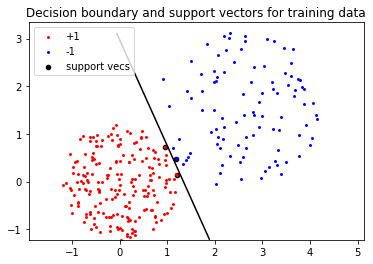

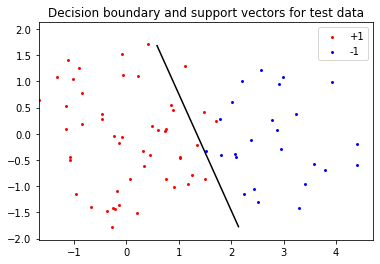

In [ ]:
# # ECS271 2019S
# # Toy example of Linear SVM
# # 4/16/2019
# # To run this code, please first install cvxpy from https://www.cvxpy.org/

# import numpy as np 
# import matplotlib
# import matplotlib.pyplot as plt
# import random
# import time
# import cvxpy as cp


# # generate toy training data 
# N1 = 200 # number of positive instances
# N2 = 100 # number of negative instances
# D = 2 # feature dimension
# eps = 1e-8 # select support vectors
# random.seed(1) # For reproducibility
# r1 = np.sqrt(1.5*np.random.rand(N1,1)) # Radius
# t1 = 2*np.pi*np.random.rand(N1,1)  # Angle
# data1 = np.concatenate((r1*np.cos(t1), r1*np.sin(t1)), axis=1) # Points
# r2 = np.sqrt(3*np.random.rand(N2,1)) # Radius
# t2 = 2*np.pi*np.random.rand(N2,1)      # Angle
# data2 = np.concatenate((2.5+r2*np.cos(t2), 1.5+r2*np.sin(t2)), axis=1) # points
# ## generate toy testing data
# Nt1 = 50 # number of positive instances
# Nt2 = 25 # number of negative instances
# D = 2 # feature dimension
# random.seed(1) # For reproducibility
# r1 = np.sqrt(3.4*np.random.rand(Nt1,1)) # Radius
# t1 = 2*np.pi*np.random.rand(Nt1,1)  # Angle
# testdata1 = np.concatenate((r1*np.cos(t1), r1*np.sin(t1)), axis=1) # Points
# r2 = np.sqrt(2.4*np.random.rand(Nt2,1)) # Radius
# t2 = 2*np.pi*np.random.rand(Nt2,1)      # Angle
# testdata2 = np.concatenate((3+r2*np.cos(t2), r2*np.sin(t2)), axis=1) # points
# ## training linear SVM based on CVX optimizer
# X = np.concatenate((data1, data2), axis=0)
# y = np.concatenate((np.ones((N1, 1)), - np.ones((N2, 1))), axis=0)

# w = cp.Variable((D, 1))
# b = cp.Variable()
# objective = cp.Minimize(cp.sum(cp.square(w)) * 0.5)
# constraints = [cp.multiply(y, (X @ w + b)) >= 1]
# prob = cp.Problem(objective, constraints)
# prob.solve()
# print("status:", prob.status)
# print("optimal value", prob.value)
# print("optimal var w = {}, b = {}".format(w.value, b.value))


# ## visualize decision boundary for training data
# d = 0.02
# x1 = np.arange(np.min(X[:,0]), np.max(X[:,0]), d)
# x2 = np.arange(np.min(X[:,1]), np.max(X[:,1]), d)
# x1Grid, x2Grid = np.meshgrid(x1, x2)
# xGrid = np.stack((x1Grid.flatten('F'), x2Grid.flatten('F')), axis=1)
# scores1 = xGrid.dot(w.value) + b.value
# scores2 = -xGrid.dot(w.value) - b.value
# plt.figure(0)
# print('X and Y Shape')
# # print(y.shape)
# # print(y)
# # print("X")
# # print(X.shape)
# # print(X)
# # print(w.value)
# sup = y*(X.dot(w.value)+b.value)-1
# # print(X.dot(w.value)+b.value)
# print(b.value)
# print(sup)
# sup_v1 = ((-eps<sup) & (sup<eps)).flatten()
# # print('Support Vecs TEst')
# # print(sup_v1.shape)
# # print(sup_v1)
# h3 = plt.scatter(X[sup_v1,0], X[sup_v1,1], s=21, marker='o', c='k')
# h1 = plt.scatter(data1[:,0], data1[:,1], s=15, marker='.', c='r')
# h2 = plt.scatter(data2[:,0], data2[:,1], s=15, marker='.', c='b')
# plt.contour(x1Grid, x2Grid, np.reshape(scores1, x1Grid.shape, order='F'), levels=0, colors='k')
# plt.axis('equal')
# plt.title('Decision boundary and support vectors for training data')
# plt.legend((h1, h2, h3),('+1','-1', 'support vecs'))
# plt.savefig('simpleSVM_train_decision_1.png')
# print("number of support vectors", np.sum(sup_v1))


# time.sleep(2)
# ## visualize decision boundary for test data
# Xt = np.concatenate((testdata1, testdata2), axis=0)
# yt = np.concatenate((np.ones((Nt1, 1)), - np.ones((Nt2, 1))), axis=0)
# xt1 = np.arange(np.min(Xt[:,0]), np.max(Xt[:,0]), d)
# xt2 = np.arange(np.min(Xt[:,1]), np.max(Xt[:,1]), d)
# xt1Grid, xt2Grid = np.meshgrid(xt1, xt2)
# xtGrid = np.stack((xt1Grid.flatten('F'), xt2Grid.flatten('F')), axis=1)
# test_scores1 = xtGrid.dot(w.value) + b.value
# test_scores2 = -xtGrid.dot(w.value) - b.value
# plt.figure(1)
# ht1 = plt.scatter(testdata1[:,0], testdata1[:,1], s=15, marker='.', c='r')
# ht2 = plt.scatter(testdata2[:,0], testdata2[:,1], s=15, marker='.', c='b')
# plt.contour(xt1Grid, xt2Grid, np.reshape(test_scores1, xt1Grid.shape, order='F'), levels=0, colors='k')
# plt.axis('equal')
# plt.title('Decision boundary and support vectors for test data')
# plt.legend((ht1, ht2),('+1','-1'))
# plt.savefig('simpleSVM_test_decision_1.png')
# plt.show()
